Здравствуйте!  
Этот проект посвящен экзопланетам. Всех нас так или иначе привлекает космос, у меня появилось желание посмотреть на него с точки зрения данных. Задача этого проекта с разных углов взглянуть на данные про экзопланеты которые есть в открытом доступе. Не могу сказать, что знал много об этой теме до проделанной работы, поэтому почти каждый вывод для меня – новость. Надеюсь вам тоже понравится, приятного просмотра!
### Техническая стороная проекта
В проекте использованы различные технологии сбора анализа и обработки данных: такие как скрэппинг с помощью Selenium, работа с API, применение SQL, анализ и обработка данных в pandas, исползуются математические методы scipy, применяется визуализация с помощью plotly, matplotlib, seaborn и networkx. Применяются технологии машинного обучения: библиотеки sklearn, pytorch, lightgbm, optuna
### В проекте будут использоваться два файла с данными:  
planets_data.csv получен с помощью вэб-скрэппинга с сайта https://exoplanet.eu/catalog/, в нём данные о всех исзвестных человечеству экзопланетах  
API_planets.csv получен с помощьюю NASA_API из него я брал некоторые дополнительные данные

## Сбор данных: вэб-скрэппинг и обращение к API

In [1]:
import datetime
import time
import pandas as pd
import numpy as np

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import Select #загружаем библиотеки

Первым делом соберем данные об экзопланетах с помощью selenium c сайта https://exoplanet.eu, где собраны данные про все известные экзопланеты (их чуть больше 5 тысяч),  на каждой странице данные структурированы в виде таблицы и обращаться к разным ячейкам по xpath не составило трудаю На первом этапе я собрал имена и ссылки на информацию о планете, затем по ссылкам собрал данные про каждую планету и получил финальный датасет

In [ ]:
service = Service()
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=service, options=options)


driver.get('https://exoplanet.eu/catalog/')
df_links = pd.DataFrame() #первые несколько ячеек будут посвящены скраппингу с помощью selenium, их можно пропустить и загрузить готовый файл


In [30]:
def wait():
    WebDriverWait(driver, 5).until(
        EC.presence_of_element_located((By.XPATH, '//*[@id="data_next"]'))
    ) #функция для того, чтобы страницы успевали загружаться

In [31]:
data = []
errors = []
for i in range(1, 58): #для 58/59 страниц
    for j in range(1, 101): #парсим 100 ячеек на каждой странице
        try:
            name  = driver.find_element(By.XPATH, f'//*[@id="data"]/tbody/tr[{j}]/td[1]/a') #ищем название планеты
            data.append([name.text, name.get_attribute("href")]) #собираем ссылку на данные
        except Exception as e:
            errors.append([i, j])
    button = driver.find_element(By.XPATH, '//*[@id="data_next"]')
    button.click()
    wait()

In [33]:
for j in range(1, 53): #то же для последней страницы, так как там 52 строки
    try:
        name  = driver.find_element(By.XPATH, f'//*[@id="data"]/tbody/tr[{j}]/td[1]/a')
        data.append([name.text, name.get_attribute("href")])
    except Exception as e:
        errors.appned([i, j])

In [34]:
len(errors) #не спарсилось не так много

40

In [35]:
df_links = pd.DataFrame(data, columns=["planet_name", "link"]) #делаем датафрейм с ссылками

In [36]:
len(df_links)

5720

In [37]:
df_links.to_csv(r"D:\project\planets.csv")

In [49]:
def get_info(link):
    try:
        driver.get(link)
        WebDriverWait(driver, 5).until(
        EC.presence_of_element_located((By.XPATH, '//*[@id="planet-detail-basic-info-header"]/button/h4')))
        star = driver.find_elements(By.CLASS_NAME, f'col-sm-8')
        star = [el.text for el in star]
        star = [el.split('\n')[0] for el in star] #функция собирающая инфу о планете с сайта планеты
        return star
    except:
        return [None] * 42


In [50]:
def get_columns(link):
    driver.get(link)
    col = driver.find_elements(By.CLASS_NAME, f'col-sm-4')
    col = [el.text for el in col]
    return col #функция собирающая названия столбцов

In [51]:
len(get_columns(df_links.iloc[3, 1])) #количество признаков

42

In [ ]:
data = []
for i, row in df_links.iterrows():
    data.append(get_info(row["link"])) #собираем данные по ссылкам

In [61]:
len(data)

5720

In [71]:
data_question = [el for el in data if len(el) != 42] #строки где что-то пошло не так

In [72]:
len(data_question)

129

In [64]:
data_needed = [el for el in data if len(el) == 42]

In [ ]:
len(data_needed)
df_planets = pd.DataFrame(data_needed, columns=get_columns(df_links.iloc[3, 1])) #датафрейм с которым будем работать


In [ ]:
df_planets.to_csv(r"D:\project\planets_data.csv") #сохраняем файл, чтобы каждый раз не проделывать скреппинг

In [2]:
df_planets = pd.read_csv(r"D:\project\planets_data.csv") #ячейка, которая загружает полученный с помощью селениума файл
df_planets = df_planets.drop("Unnamed: 0", axis=1)
df_planets = df_planets.dropna(subset=['Name'])

In [3]:
len(df_planets)

5585

In [4]:
import wget

К собранным данным добавим ещё несколько признаков: координаты, плотность планеты, параллакс. Их получим с помощью NASA API и с трудом сконструированного запроса туда. Полученные данные обработаем с помощью SQL.

In [5]:
url = 'https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps&format=csv'
path = "D:\\project\\API_planets.csv" #собираем данные с помощью запроса к NASA API

In [ ]:
distance_df = wget.download(url, path)

In [6]:
import sqlite3


conn = sqlite3.connect(':memory:')  
cur = conn.cursor()


table_name = 'Dist'  

df = pd.read_csv(path)
df.to_sql(table_name, conn, if_exists='replace', index=False)

selected_columns = ['pl_name', 'pl_dens', "sy_plx", 'ra', "dec"] #с помощью SQL выбираем из полученного файла нужны признаки
query = f"SELECT {', '.join(selected_columns)} FROM {table_name}"
distance_df = pd.read_sql_query(query, conn)

conn.close()


C:\Users\Asus\AppData\Local\Temp\ipykernel_41276\606644514.py:10: DtypeWarning: Columns (50,65,148,153,183,187,206,211,237,242) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Смерджим два датасета по имени планеты и удалим получившиеся дубликаты

In [7]:
distance_df["merge"] = distance_df["pl_name"].apply(lambda x: x.upper()) #создаем колонку по которой будем объединять два датасета
df_planets["merge"] = df_planets["Name"].apply(lambda x: x.upper())


In [8]:
distance_df.head()

,pl_name,pl_dens,sy_plx,ra,dec,merge
0,OGLE-TR-10 b,0.4,0.72138,267.867748,-29.876476,OGLE-TR-10 B
1,BD-08 2823 b,NaN,24.16410,150.197196,-9.516569,BD-08 2823 B
2,BD-08 2823 c,NaN,24.16410,150.197196,-9.516569,BD-08 2823 C
3,HR 8799 c,NaN,24.21750,346.870149,21.134038,HR 8799 C
4,HD 104985 b,NaN,9.91460,181.315785,76.905336,HD 104985 B


In [153]:
#df_planets.columns.values[28] = "Star_Name"
#df_planets.columns.values[32] = "Star_Mass"
#df_planets.columns.values[35] = "Star_Radius"
#df_planets.columns.values[-1] = "Star_Alt_Names" если работаем с датафреймом, который только спарсили, то используем этот код для переименования

In [9]:
df_planets= df_planets.rename(columns={'Mass.1': 'Star_Mass', 'Name.1': 'Star_Name', 'Radius.1': 'Star_Radius', 'Alternate Names.1': 'Star_AltName'}) #переименуем некоторые строки

In [10]:
df_planets = pd.merge(df_planets, distance_df, on="merge", how="left") #добавим к основному датафрейму признаки, полученные с помощью NASA API

In [11]:
df_planets = df_planets.drop_duplicates(subset="merge", keep="first") #в результате некоторые строки продублировались, отбросим их, первая строка всегда та, что была в изначальном датафрейме

## Описание переменных
Итак, имеем финальный датасет, с которым будем работать, давайте поближе познакомимся с переменными:  
__Name__ – название планеты  
__Planet Status__ – статус планеты: подтверждено ли её существование  
__Discovered in__ – год открытия планеты  
__Mass__ – масса планеты в массах Юпитера  
__Mass*sin(i)__ – минимальная масса планеты, измеренная с помощью радиальной скорости  
__Semi-Major Axis__ – Большая полуось орбиты  
__Orbital Period__ – Период обращения планеты  
__Eccentricity__ – Эксцентриситет орбиты (мера некруглости)  
__ω__ – Яркость планеты  
__Tperi__ – Время прохождения периастрона, ближайшей точки к здезде на орбите 
__Radius__ – Радиус планеты  
__Inclination__ – Наклон орбиты  
__Update__ – Последнее обновление информации о планете  
__Detection Method__ – Метод, с помощью которого обнаружили планету  
__Mass Detection Method__ – Метод, с помощью которого определили массу  
__Radius Detection Method__ – Метод, с помощью которого определили радиус  
__Primary transit__ – Дата первого зафиксированного прохода перед звездой в JD  
__Secondary transit__ – Дата второго зафиксированного прохода перед звездой в JD  
__λ__ – Вероятность(в %) того что это действительно планета (не смог найти точную информацию)  
__Impact Parameter b__ – Упрощая, то, насколько звезда влияет на орбиту планеты.  
__Time Vr=0__ – Время начального положения планеты на своей орбите (0, 0, 0) в трехмерном пространстве  
__Velocity Semiamplitude K__ – Максимальная разница между максимальной и минимальной скоростью звезды   
__Calculated temperature__ – Рассчитанная температура (К)  
__Measured temperature__ – Измеренная температура  
__Hottest point longitude__ – Долгота самой горячей точки  
__Geometric albedo__ – Доля света, отражаемая телом  
__Surface gravity log(g/gH)__ – Гравитация планеты  
__Alternate Names__ – Другие названия планеты  
__Star_Name__ – Название звезды,на орбите которой находится планета  
__Distance__ – Расстояние до звезды (в парсеках)  
__Spectral type__ – Спектральный тип звезды  
__Apparent magnitude V__ – Мера яркости звезды  
__Star_Mass__ – Масса звезды  
__Age__ – Возраст звезды  
__Effective temperature__ – Температура звезды  
__Star_Radius__ – Радиус звезды  
__Metallicity__ – Содержание металла в звезде (по отношению к водороду)  
__Detected Disc__ – Есть ли более сильный разброс энергии звезды  
__Magnetic Field__ – Магнитное поле звезды  
__RA2000__ – Правое отклонение звезды (6-значное)  
__DEC2000__ – Склонение звезды (6-значное)  
__Star_AltName__ – Другие названия звезды  
__pl_dens__ – Плотность планеты  
__sy_plx__ – Параллакс звездной системы  
__ra__ – Правое отклонение звездной системы  
__dec__ – Склонение звездной системы  

In [12]:
df_planets = df_planets.drop(["merge", "pl_name"], axis=1)

In [13]:
len(df_planets) #проверим количество планет с которыми в итоге будем работать

5560

## Обработка данных

Далее обработаем пропуски и подготовим данные к анализу

In [14]:
df_planets = df_planets.replace('—',pd.NA, regex=True) #обработаем пропуски, которые на сайте --

In [15]:
df_planets.sample(3)


,Name,Planet Status,Discovered in,Mass,Mass*sin(i),Semi-Major Axis,Orbital Period,Eccentricity,ω,Tperi,...,Metallicity [Fe/H],Detected Disc,Magnetic Field,RA2000,Dec2000,Star_AltName,pl_dens,sy_plx,ra,dec
29649,HAT-P-43 b,Confirmed,2012,0.66,<NA>,0.0443,3.332688,<NA>,<NA>,<NA>,...,0.23,<NA>,<NA>,08:35:42.0,+10:12:24.1,<NA>,NaN,1.86227,128.925689,10.206587
777,WASP-12 b,Confirmed,2008,1.47,1.46,0.02344,1.09141937,<NA>,<NA>,<NA>,...,0.3,<NA>,<NA>,06:30:33.0,+29:40:20.0,<NA>,NaN,2.31224,97.636645,29.672266
839,KMT-2023-BLG-0469 b,Confirmed,2024,0.124,<NA>,2.37,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,17:57:37.6,-28:42:54.2,<NA>,NaN,NaN,NaN,NaN


In [16]:
def destring(x):
    try:
        if not pd.isnull(x):
            return float(x)
        else:
            return x
    except:
        try:
            if not pd.isnull(x):
                return float(x.split()[0])
            else:
                return x
        except:
            return pd.NA #функция, которая убирает нечисловые элементы из строки и переводит все в числа

In [17]:
numcolumns = ['Discovered in', 'Mass', 'Mass*sin(i)', 'Semi-Major Axis', 'Orbital Period', 'Eccentricity', 'ω', 'Tperi', 'Radius', 'Inclination', 'Primary transit',
       'Secondary transit', 'λ', 'Impact Parameter b', 'Time Vr=0',
       'Velocity Semiamplitude K', 'Calculated temperature',
       'Measured temperature', 'Hottest point longitude', 'Geometric albedo',
       'Surface gravity log(g/gH)', 'Distance', 'Apparent magnitude V', 'Star_Mass', 'Age',
       'Effective temperature', 'Star_Radius', 'Metallicity [Fe/H]', 'pl_dens', "sy_plx", 'ra', "dec"] #это список числовых признаков

In [18]:
for el in numcolumns:
    df_planets[el] = df_planets[el].apply(destring) 

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df_planets = df_planets.replace(pd.NA, None, regex=True)
df_planets = df_planets.replace(np.nan, None, regex=True) #заменяем все наны на нан из питона

## Анализ данных. Общая информация

Посмотрим на информацию о датасете и построим корреляционную матрицу некотрых переменных, к сожалению, очень мало переменных есть для всех планет

In [22]:
df_planets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5560 entries, 0 to 32325
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Name                       5560 non-null   object
 1   Planet Status              5560 non-null   object
 2   Discovered in              5549 non-null   object
 3   Mass                       3016 non-null   object
 4   Mass*sin(i)                1182 non-null   object
 5   Semi-Major Axis            3856 non-null   object
 6   Orbital Period             5149 non-null   object
 7   Eccentricity               1859 non-null   object
 8   ω                          1468 non-null   object
 9   Tperi                      828 non-null    object
 10  Radius                     4024 non-null   object
 11  Inclination                1655 non-null   object
 12  Update                     5560 non-null   object
 13  Detection Method           5560 non-null   object
 14  Mass Detecti

In [23]:
df_planets.describe()

,Name,Planet Status,Discovered in,Mass,Mass*sin(i),Semi-Major Axis,Orbital Period,Eccentricity,ω,Tperi,...,Metallicity [Fe/H],Detected Disc,Magnetic Field,RA2000,Dec2000,Star_AltName,pl_dens,sy_plx,ra,dec
count,5560,5560,5549.0,3016.0,1182.0,3856.0,5149.0,1859.00,1468.0,8.280000e+02,...,4295.00,92,4,5560,5560,3462,329.0,4341.00000,4607.000000,4607.000000
unique,5560,1,32.0,1728.0,863.0,2134.0,5127.0,503.00,881.0,8.080000e+02,...,470.00,2,2,4136,4193,2478,271.0,3180.00000,3406.000000,3406.000000
top,TOI-1758 b,Confirmed,2016.0,2.3,1.9,2.0,562.0,0.03,90.0,2.457376e+06,...,0.04,IR Excess,Yes,18:57:44.0,+49:18:18.6,"KOI-351, 2MASS J18574403+4918185, KIC 11442793...",0.9,2.67801,346.626392,-5.043462
freq,1,5560,1513.0,12.0,8.0,15.0,2.0,40.00,13.0,4.000000e+00,...,142.00,64,3,8,8,8,4.0,6.00000,7.000000,7.000000


In [22]:
df_planets[numcolumns].head()

,Discovered in,Mass,Mass*sin(i),Semi-Major Axis,Orbital Period,Eccentricity,ω,Tperi,Radius,Inclination,...,Apparent magnitude V,Star_Mass,Age,Effective temperature,Star_Radius,Metallicity [Fe/H],pl_dens,sy_plx,ra,dec
0,2024.0,0.0217,None,0.138,20.705127,None,None,None,0.303,None,...,None,0.88,None,5170.0,0.8,None,None,None,None,None
1,2024.0,0.0151,None,0.081,8.0824,None,None,None,0.2471,None,...,None,None,None,5878.0,None,None,None,None,None,None
2,2024.0,0.0327,None,0.114,13.72641,None,None,None,3.0,None,...,None,1.03,None,None,1.09,None,None,None,None,None
3,2015.0,None,None,0.161,31.8099,None,None,None,0.37,89.3,...,None,1.15,None,6116.46,1.256,-0.051,None,None,None,None
4,2015.0,None,None,0.3654,75.2,None,None,None,0.21,89.701,...,None,1.15,None,6116.46,1.256,-0.051,None,None,None,None


In [23]:
corrcolumns = ['Discovered in', 'Mass',  'Orbital Period', 'Eccentricity', 'Inclination', 'Primary transit', 'Radius', 'Impact Parameter b',
       'Velocity Semiamplitude K', 'Calculated temperature',
       'Measured temperature', 'ω', 'Geometric albedo','Distance', 'Star_Mass', 'Age',
       'Effective temperature', 'Metallicity [Fe/H]', 'sy_plx', 'pl_dens' ]

Пожалуй, матрица корреляций самый интересный график этого проекта, по нейможно сделать очень много выводов и узнать много фактов, например:  
Радиус положительно связан с температурой: действительно, газовые планеты в среднем горячее  
Возраст звезды отрицательно связан с температурой на окружающих планетах, так как звезда со временем выгорает (как и мы все)  
По этой матрице можно вспомнить формулу плотности  
Альбедо связано очень много с чем, что понятно, так как многие показатели считаются по отражаемому свету, а альбедо это и измеряет  
На самом деле здесь есть ещё много всего, я потратил достаточно много времени, разглядываю эту картинку


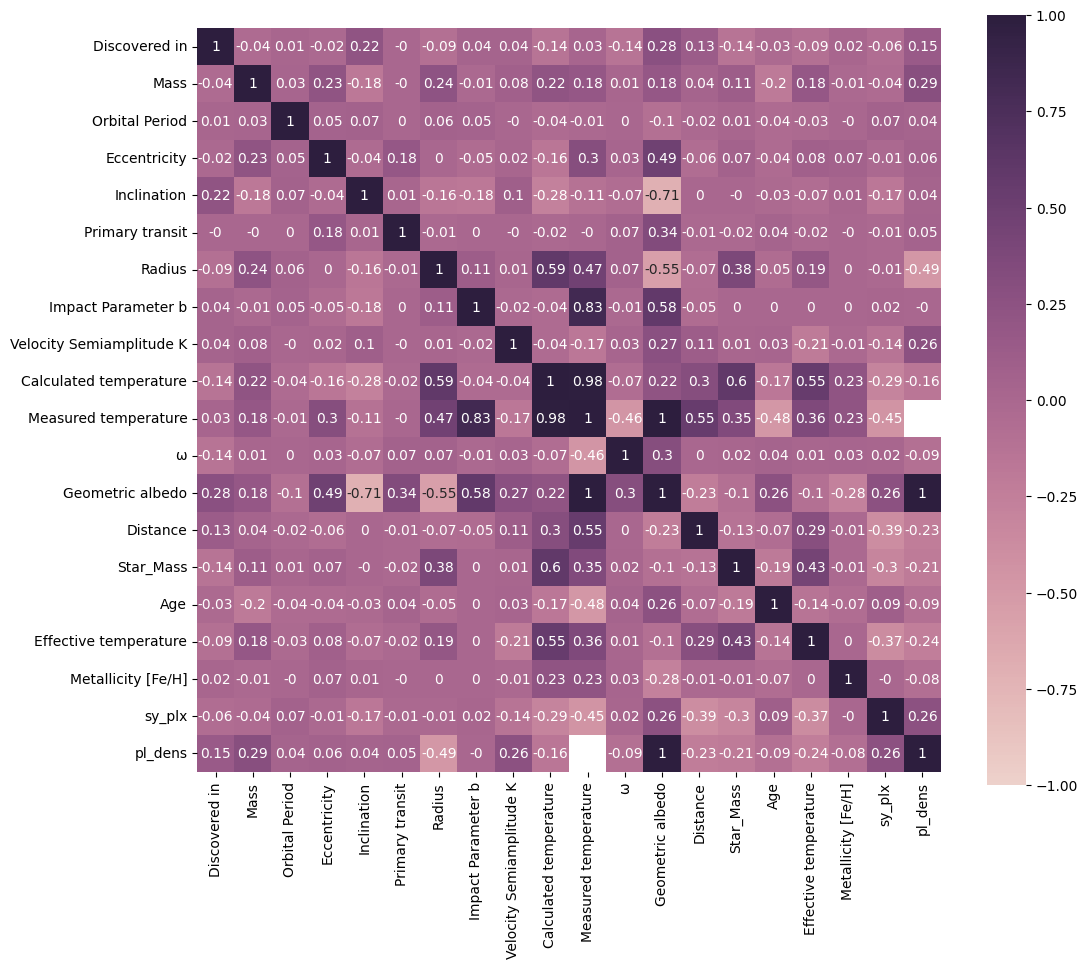

In [24]:
corr_matrix = df_planets[corrcolumns].corr() #считаем матрицу корреляция для избранных признаков
corr_matrix = corr_matrix.round(decimals=2)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap=sns.cubehelix_palette(as_cmap=True), annot=True, vmin=-1, vmax=1, square=True)
plt_corrmap = plt
plt.show()

Далее давайте узнаем про наши переменные побольше, построим их распределения и проверим их на нормальность

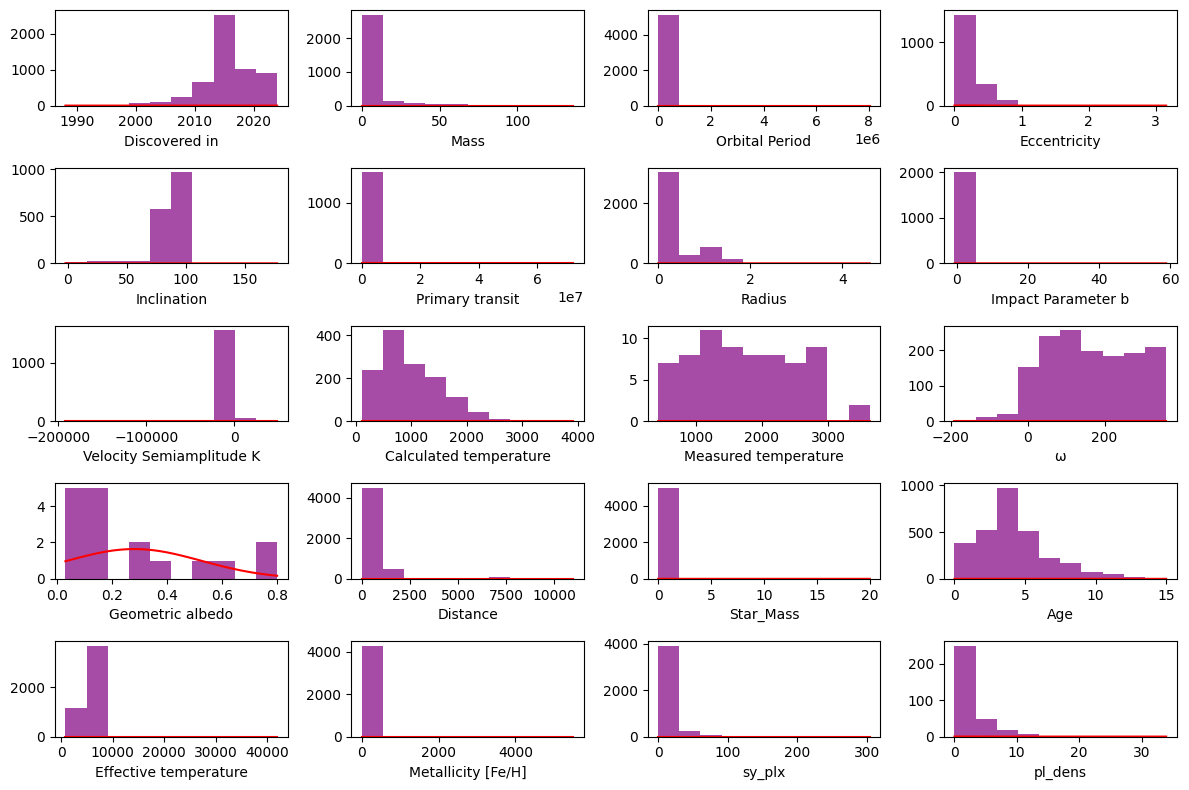

In [25]:
rows = 5
cols = 4

fig, axs = plt.subplots(rows, cols, figsize=(12, 8)) #строим панель с распределением признаков 

for i, ax in enumerate(axs.flat):
    bool_idx = df_planets[corrcolumns[i]].isnull()
    for_plot = df_planets[corrcolumns[i]][~bool_idx]
    ax.hist(for_plot, bins=10, color="purple", alpha=0.7)
    ax.plot(np.linspace(np.min(for_plot), np.max(for_plot), 100),
1 / (np.sqrt(2 * np.pi * np.var(for_plot))) *
np.exp(-(np.linspace(np.min(for_plot), np.max(for_plot), 100) - np.mean(for_plot)) ** 2 /
(2 * np.var(for_plot))),
color='r')#добавим на панель график нормального распределения с такими же параметрами как у признака
    ax.set_xlabel(corrcolumns[i])

plt.tight_layout()
plt_desc = plt.show()
plt.show()

In [26]:
#С помощью теста Колмогорова-Смирнова проверим имеет ли какая-то из переменных нормальное распределение:
from scipy.stats import kstest
for i in range(20):
    bool_idx = df_planets[corrcolumns[i]].isnull()
    for_test = df_planets[corrcolumns[i]][~bool_idx].values
    test_stat = kstest(np.asfarray(for_test), 'norm')
    print(f"переменная {corrcolumns[i]} имеет нормальное распределение с вероятностью {test_stat[1]}")



переменная Discovered in имеет нормальное распределение с вероятностью 0.0
переменная Mass имеет нормальное распределение с вероятностью 0.0
переменная Orbital Period имеет нормальное распределение с вероятностью 0.0
переменная Eccentricity имеет нормальное распределение с вероятностью 0.0
переменная Inclination имеет нормальное распределение с вероятностью 0.0
переменная Primary transit имеет нормальное распределение с вероятностью 0.0
переменная Radius имеет нормальное распределение с вероятностью 0.0
переменная Impact Parameter b имеет нормальное распределение с вероятностью 0.0
переменная Velocity Semiamplitude K имеет нормальное распределение с вероятностью 0.0
переменная Calculated temperature имеет нормальное распределение с вероятностью 0.0
переменная Measured temperature имеет нормальное распределение с вероятностью 0.0
переменная ω имеет нормальное распределение с вероятностью 0.0
переменная Geometric albedo имеет нормальное распределение с вероятностью 0.00011647850813868787

ЦПТ в нашем случае не сработала, хотя и вообще не была обязана. Для будущих частей важно запомнить, что все переменные содержат выбросы.

## Анализ расположения планет

Далее разберемся в географии открытых экзопланет. Построим их сначала в экваториальных координатах (угол подъёма, угол поворота над экватором Земли), а затем и в трёхмерном пространстве, перейдя от полярных координат к декартовым с центром в Земле.

In [24]:
df_map = df_planets.dropna(subset=["ra", "dec", "Distance"]) #оставляем только планеты, для которых мы получили координаты

In [25]:
len(df_map)

4436

In [199]:
import plotly.express as px
from astropy.coordinates import SkyCoord
import astropy.units as u

coords = SkyCoord(ra=df_map['ra']*u.deg, dec=df_map['dec']*u.deg, frame='icrs', unit='deg') #преобразуем координаты с помощью astropy

df_map["Right Ascension (RA)"] = coords.icrs.ra.to(u.deg)
df_map["Declination (Dec)"] = coords.icrs.dec.to(u.deg)

df_map = df_map[["Name", "Right Ascension (RA)", "Declination (Dec)", "Distance"]] #создаём датафрейм только из нужных нам признаков

fig = px.scatter(df_map, x="Right Ascension (RA)", y = "Declination (Dec)", labels = {"x":'Right Ascension (RA)', "y":'Declination (Dec)'}, title='Exoplanets in the Galaxy in equatorial coordinates', hover_data="Name")

fig.show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_39224\1863146068.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Asus\AppData\Local\Temp\ipykernel_39224\1863146068.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Как видно, планеты расположены достаточно равномерно, однако есть скопления. Как несложно догадаться, каждое соответствует работе определнного телескопа. Так, например, в правом верхнем углу работа телескопа Кеплер, а вдоль экватора К2. Это можно понять, наведя курсор на планеты, тогда появится их название

In [201]:

df_map["x"] = df_map["Distance"]* np.cos(np.radians(df_map["Right Ascension (RA)"])) * np.sin(np.radians(df_map["Declination (Dec)"]))
df_map["y"] = df_map["Distance"] * np.sin(np.radians(df_map["Right Ascension (RA)"])) * np.sin(np.radians(df_map["Declination (Dec)"]))
df_map["z"] = df_map["Distance"] * np.cos(np.radians(df_map["Declination (Dec)"]))

# Строим трехмерную карту
fig = px.scatter_3d(df_map, x='x', y='y', z='z', hover_data="Name", title='Geocentric map of exoplanets')

# Настройка внешнего вида

fig.update_layout(width=1000, height=800, scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

# Отображение карты
fig.show()


Трёхмерная карта подтверждает наши догадки про телескопы. Мы имеем облако рядом с землёй и несколько лучей, которые соответствуют работе телескопов в определённом направлении.

Далее давайте ответим на самый животрепещущий вопрос по теме. Какая ближайшая к нам планета, пригодная для жизни?  
К сожалению, данных по наличию атмосферы у нас нет, но есть по температуре. Найдем ближайшую планету с пригодным температурным режимом. Я не любитель экстремальных температур, поэтому поставим -20-+30 С.


In [52]:
closest = list(df_planets["Distance"].sort_values(ascending=True).head(10)) #выберем 10 ближайших к Земле планет

In [127]:
df_planets[(df_planets['Distance'].isin(closest)) & 
                           (df_planets['Calculated temperature'] > 250) &  #проверим есть ли где-то комфортная температура (+30 -20)
                           (df_planets['Calculated temperature'] < 300)]

,Name,Planet Status,Discovered in,Mass,Mass*sin(i),Semi-Major Axis,Orbital Period,Eccentricity,ω,Tperi,...,Magnetic Field,RA2000,Dec2000,Star_AltName,merge,pl_name,pl_dens,sy_plx,ra,dec
30034,Ross 128 b,Confirmed,2017.0,0.0044,0.0044,0.0496,9.8658,0.116,None,None,...,None,11:47:44.0,+00:48:16.0,None,ROSS 128 B,Ross 128 b,None,296.307,176.937604,0.79929


Вот она! Планета Ross128b в 3.3806 парсеках от Земли. Она хоть и относительно маленькая, всего 0.0044 массы Юпитера, но зато температурный режим идеальный.

Давайте поговорим о звёздах, к сожалению проект про астрологию делали в прошлом году, поэтому просто найдём звезду с наибольшим количеством открытых планет на её орбите. Для этого сгруппируем наш датасет и аггрегируем признаки.

In [54]:
stars = df_planets.groupby("Star_Name", group_keys=True).agg({'Name': 'count', 'Radius':'mean', 'Mass':'mean', 'Star_Mass':'first', 'Age':'first', 'Effective temperature':'first', 'Star_Radius':'first', 'Metallicity [Fe/H]':'first',}).reset_index()
#создаем датафрейм со звездами, обрабатывая старые признаки

In [55]:
stars= stars.rename(columns={'Name': 'Num_Planets'})
stars.sample(3)


,Star_Name,Num_Planets,Radius,Mass,Star_Mass,Age,Effective temperature,Star_Radius,Metallicity [Fe/H]
2481,Kepler-317,2,0.1695,NaN,0.95,None,5497.0,0.94,0.258
3864,TOI-674,1,0.4693,0.0739,0.442,5.5,3505.0,0.421,0.114
1569,Kepler-1028,1,0.119,NaN,0.9,4.68,5522.0,0.87,-0.09


Мы нашли звезду Kepler-90, в ней целых 8 планет, прямо как в Солнечной системе, давайте посмотрим на эту систему подробнее, для этого построим её модель.

In [56]:
stars[stars["Num_Planets"] == max(stars["Num_Planets"])] #ищем звезду с наибольшим количеством планет

,Star_Name,Num_Planets,Radius,Mass,Star_Mass,Age,Effective temperature,Star_Radius,Metallicity [Fe/H]
3107,Kepler-90,8,0.35275,NaN,1.2,None,6080.0,1.2,-0.12


In [57]:
df_planets[df_planets["Star_Name"] == "Kepler-90"]
planets_kepler90 = df_planets[df_planets["Star_Name"] == "Kepler-90"]["Name"].values.tolist()
star = "Kepler-90"

In [58]:
df_planets[df_planets["Star_Name"] == "Kepler-90"]

,Name,Planet Status,Discovered in,Mass,Mass*sin(i),Semi-Major Axis,Orbital Period,Eccentricity,ω,Tperi,...,Magnetic Field,RA2000,Dec2000,Star_AltName,merge,pl_name,pl_dens,sy_plx,ra,dec
3446,Kepler-90 h,Confirmed,2013.0,None,None,1.01,331.60059,None,None,None,...,None,18:57:44.0,+49:18:18.6,"KOI-351, 2MASS J18574403+4918185, KIC 11442793...",KEPLER-90 H,None,None,None,None,None
3447,Kepler-90 c,Confirmed,2013.0,None,None,0.089,8.719375,None,None,None,...,None,18:57:44.0,+49:18:18.6,"KOI-351, 2MASS J18574403+4918185, KIC 11442793...",KEPLER-90 C,None,None,None,None,None
3448,Kepler-90 d,Confirmed,2013.0,None,None,0.32,59.73667,None,None,None,...,None,18:57:44.0,+49:18:18.6,"KOI-351, 2MASS J18574403+4918185, KIC 11442793...",KEPLER-90 D,None,None,None,None,None
3449,Kepler-90 e,Confirmed,2013.0,None,None,0.42,91.93913,None,None,None,...,None,18:57:44.0,+49:18:18.6,"KOI-351, 2MASS J18574403+4918185, KIC 11442793...",KEPLER-90 E,None,None,None,None,None
3450,Kepler-90 b,Confirmed,2013.0,None,None,0.074,7.008151,None,None,None,...,None,18:57:44.0,+49:18:18.6,"KOI-351, 2MASS J18574403+4918185, KIC 11442793...",KEPLER-90 B,None,None,None,None,None
3451,Kepler-90 f,Confirmed,2013.0,None,None,0.48,124.9144,0.01,None,None,...,None,18:57:44.0,+49:18:18.6,"KOI-351, 2MASS J18574403+4918185, KIC 11442793...",KEPLER-90 F,None,None,None,None,None
3452,Kepler-90 g,Confirmed,2013.0,None,None,0.71,210.60697,None,None,None,...,None,18:57:44.0,+49:18:18.6,"KOI-351, 2MASS J18574403+4918185, KIC 11442793...",KEPLER-90 G,None,None,None,None,None
27474,Kepler-90 i,Confirmed,2017.0,None,None,0.2,14.44912,None,None,None,...,None,18:57:44.0,+49:18:18.6,"KOI-351, 2MASS J18574403+4918185, KIC 11442793...",KEPLER-90 I,Kepler-90 i,None,1.15007,284.433464,49.305124


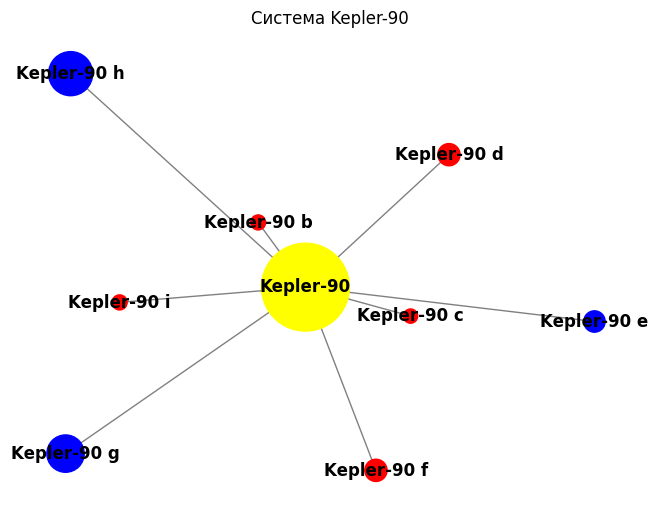

In [190]:
import networkx as nx

G = nx.Graph()
colors = ["yellow"] #создаем списки, куда записываем цвет, которым изображать планету в зависимости от температуры, и её размер
size = [4000]

G.add_node(star, type='star')

for i in range(8):
    G.add_node(planets_kepler90[i], type='planet') #создаем вершину
    size.append(df_planets[df_planets["Name"] == planets_kepler90[i]]["Radius"].iloc[0] * 1000) #добавляем размер
    if df_planets[df_planets["Name"] == planets_kepler90[i]]["Calculated temperature"].iloc[0] >500: #добавляем цвет в зависимости от температуры
        colors.append("red")
    elif df_planets[df_planets["Name"] == planets_kepler90[i]]["Calculated temperature"].iloc[0] <270:
        colors.append("lightblue")
    else:
        colors.append("blue")

for i in range(8):
    G.add_edge(star, planets_kepler90[i], weight=1/df_planets[df_planets["Name"] == planets_kepler90[i]]["Semi-Major Axis"].iloc[0]) #создаем ребра, длины которых соотносятся также как длины больших полуосей орбиты

pos = nx.spring_layout(G)

nx.draw(G, pos, with_labels=True, node_color=colors, node_size=size, font_weight='bold', font_color='black', edge_color='gray')
plt.title('Система Kepler-90')
plt.show()


Большинство планет вокруг неё небольшие и с явно неприятным климатом, но есть и планеты в обитаемой зоне

## Методы изучения экзопланет

Мне всегда было интересно узнать, как открываются планеты, давайте углубимся в методы исследования экзопланет, посмотрим, как их открывают.

In [61]:
method_freq = df_planets.groupby(['Discovered in', 'Detection Method']).size().reset_index(name='Frequency') #создаём датафрейм, в котором будет информация о методах обнаружения планет
method_freq["Discovered in"] = method_freq["Discovered in"].apply(int)

In [62]:
print(method_freq["Detection Method"].nunique())
method_freq["Detection Method"] = method_freq["Detection Method"].apply(lambda x: x if x in ["Radial Velocity", "Microlensing", "Primary Transit", "Imaging", "Timing"] else "Other") #заменяем все методы кроме самых популярных на Other
print(method_freq["Detection Method"].nunique())
method_freq = method_freq.groupby(['Discovered in', 'Detection Method']).sum().unstack() #суммируем количество обнаруженных планет каждым методом в каждом году


12
6


<Figure size 1200x800 with 0 Axes>

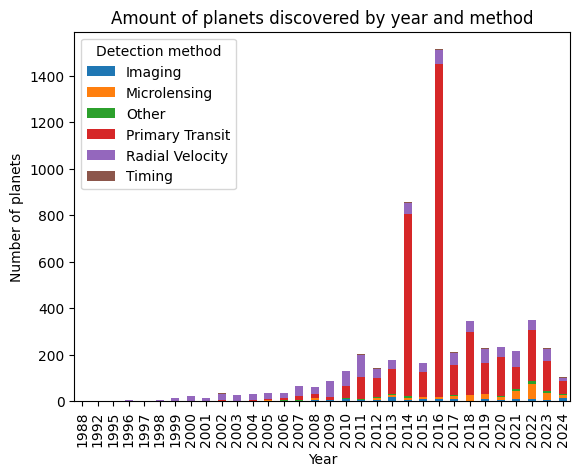

In [63]:

plt.figure(figsize=(12, 8))
method_freq.plot(kind='bar', stacked=True)
plt.title('Amount of planets discovered by year and method')
plt.xlabel('Year')
plt.ylabel('Number of planets')
plt.legend(["Imaging", "Microlensing", "Other", "Primary Transit", "Radial Velocity", "Timing"], title='Detection method')
plt.show();


Я выделил несколько самых популярных методов:  
__Imaging__ – метод, при котором с помощью телескопов свет планет отделяется от света звезды и получаются их прямые снимки  
__Microlensing__ – чтобы открыть планету с помощью этого метода нужно посмотреть на искажения в свете звезды, которое может быть вызвано экзопланетой  
__Primary Transit__ – а можно просто увидеть экзопланету в свете звезды  
__Radial Velocity__ – здесь мы смотрим на движение звезды и её орбиту, планеты вокруг могут влиять на это  
__Timing__ – Этот метод подходит для систем с несколькими планетами: если уже у открытой планеты нерегулярный период обращения, то вероятно, в системе есть тело, гравитация которого влияет на открытую планету, возможно это другая планета   
Как бы скучно это ни звучало, но самый популярный метод открытия экзопланет это дождаться их прохождения перед звездой и увидеть их и это несильно меняется с течением времени.

In [32]:
mass_freq = df_planets.groupby(['Discovered in', 'Mass Detection Method']).size().reset_index(name='Frequency') #создаём датафрейм, в котором будет информация о методах обнаружения планет
mass_freq["Discovered in"] = mass_freq["Discovered in"].apply(int)
mass_freq = mass_freq.groupby(['Discovered in', 'Mass Detection Method']).sum().unstack()

<Figure size 1200x800 with 0 Axes>

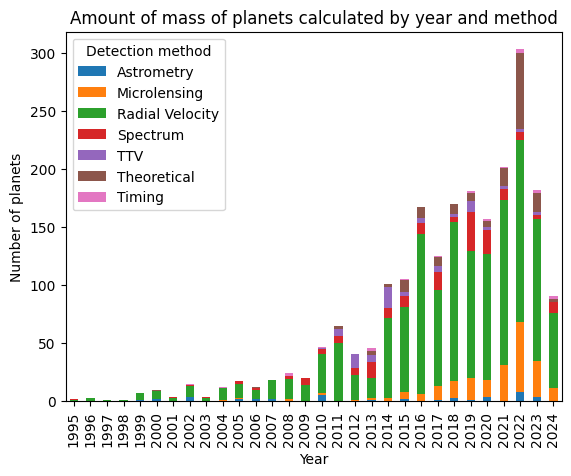

In [35]:
plt.figure(figsize=(12, 8))
mass_freq.plot(kind='bar', stacked=True)
plt.title('Amount of mass of planets calculated by year and method')
plt.xlabel('Year')
plt.ylabel('Number of planets')
plt.legend(["Astrometry", "Microlensing", "Radial Velocity", "Spectrum", "TTV", "Theoretical", "Timing"], title='Detection method')
plt.show();

Кроме знаомых нам методов для определния массы используют:  
__Astrometry__ – метод, который определяет массу на основе данных о движениях небесных тел  
__Spectrum__ – метод, основанный на анлизе спектра излучений тела   
__TTV__ – вариация метода Timing  
__Theoretical__ – с помощью теоретических моделей систем  
Можно заметить, что чаще всего массу вычисляют на основе данных об орбитах и их форме, что часто может быть затруднительно, потому что орбиты надо знать. Это объяняет, почему масса есть далеко не у всех планет.

Попробуем определить массу планеты другим способом: переходим к части машинного обучения. Мы попытаемся предсказать массу по имющимся количественным признакам (кроме плотности, разумеется). Гипотеза в том, что получится так себе, потому что много признаков вычисляются на основе анализа отражаемого света, а массу так вычислить сложно, это в основном делают засчет объектов, находящихся рядом и их влияния на орбиты. Мы используем три модели: Линейную регрессию, Нейронную сеть и Градиентный бустинг и сравним их. Метрикой качества выберем МАЕ, так как в нашей задаче хорошо бы не придавать выбросам много значения, как это делает MSE.

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [163]:
traincol = ['Discovered in', 'Radius', 'Semi-Major Axis', 'Orbital Period', 'Eccentricity', 'ω', 'Tperi',  'Inclination', 'Primary transit',
       'Secondary transit', 'λ', 'Impact Parameter b', 'Time Vr=0',
       'Velocity Semiamplitude K', 'Calculated temperature',
       'Measured temperature', 'Hottest point longitude', 'Geometric albedo',
       'Surface gravity log(g/gH)', 'Distance', 'Apparent magnitude V', 'Star_Mass', 'Age',
       'Effective temperature', 'Star_Radius', 'Metallicity [Fe/H]', 'sy_plx'] #выбираем признаки, на которых будем учить модель, исключаем категориальные, массу и плотность

In [164]:
df_ml = df_planets.dropna(subset="Mass")
y = np.asfarray(df_ml["Mass"].values)
X = df_ml[traincol].fillna(0).values
X_train, X_test, y_train, y_test = train_test_split( #делим выборку на трейн и тест,будем пользоваться этим делением и дальше для всех моделей
    X, y, test_size=0.2, random_state=142)

linreg = LinearRegression()
linreg.fit(X_train, y_train) #тренируем и считаем ошибки на тесте для линейной регрессии
y_pred = linreg.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

MSE: 140.86335059663742
MAE: 6.4108713414691945


C:\Users\Asus\AppData\Local\Temp\ipykernel_39224\296330676.py:3: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Линейная регрессия в нашем случае некоторый бейзлайн, чтобы нам было с чем сравнивать.

In [165]:
import torch, torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output

In [151]:
def iterate_minibatches(data, data_ans, batch_size=200, shuffle=True, cycle=False, **kwargs):
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices) #выбираем рандомные наблюдения

        for start in range(0, len(indices), batch_size):
            batch = data[start : start + batch_size]
            target = data_ans[start : start + batch_size] #создаем батч и таргет из данных
            yield batch, target

        if not cycle:
            break

In [152]:
iterator = iterate_minibatches(X_train, y_train)
batch, target = next(iterator)

In [172]:
class Net(nn.Module): #пишем нейросеть
    def __init__(
        self
    ):
        super().__init__()

        self.res1 = nn.Sequential( #несколько линейных слоев с функциями активации, используем батчнорм для стандартизации данных и дропаут для избежания переобучения
              nn.Linear(27, 64),
              nn.GELU(),
              nn.Linear(64, 128),
              nn.BatchNorm1d(128),
              nn.GELU(),
              nn.Linear(128, 256),
              nn.GELU(),
              nn.Linear(256, 512),
              nn.GELU(),
              nn.Linear(512, 1024),
              nn.GELU(),
              nn.Dropout(),
              nn.Linear(1024, 512),
              nn.GELU(),
              nn.Linear(512, 256),
              nn.GELU(),
              nn.Linear(256, 128),
              nn.GELU(),
              nn.BatchNorm1d(128),
              nn.Linear(128, 64),
              nn.GELU(),
              nn.Linear(64, 16),
              nn.GELU(),
              nn.Linear(16, 1))

    def forward(self, batch):

        out_ = self.res1(batch) #при тренировке применяем модель на данных


        return(out_)

In [173]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [174]:
model = Net()
model.to(device);

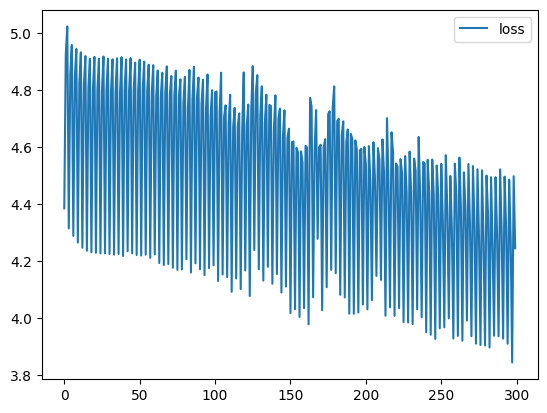

In [175]:
from IPython.display import clear_output

epochs = 100 #количество проходов по батчам

opt = torch.optim.Adam(model.parameters(), lr = 0.001) #в качестве оптимизатора выберем Адам
criterion = nn.L1Loss() #в качестве функции потерь МАЕ
history = []
for epoch in range(epochs):
    for batch, target in iterate_minibatches(X_train, y_train, batch_size=1000):

        batch = torch.tensor(batch, dtype=torch.float32, device=device)

        target = torch.tensor(target, dtype=torch.float32, device=device) #переводим данные в тензоры

        predictions = model(batch).view(-1)

        loss = criterion(predictions, target)

        opt.zero_grad() 
        loss.backward()
        opt.step() #учим модель

        history.append(loss.item()) #отображаем кривую обучения
        if len(history) % 100 == 0:
            clear_output(wait=True)
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

In [176]:
model.eval()
y_pred = model(torch.tensor(X_test, dtype=torch.float32, device=device))
print(f"MSE: {mean_squared_error(y_test, y_pred.detach().numpy())}")
print(f"MAE: {mean_absolute_error(y_test, y_pred.detach().numpy())}")

MSE: 163.79915138123738
MAE: 5.113879237293636


In [177]:
from lightgbm import LGBMRegressor

In [178]:
gbm = LGBMRegressor(num_leaves = 8, max_depth = 4, learning_rate = 0.1, n_estimators=20) #тренируем и смотрим на результаты градиентного бустинга
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4807
[LightGBM] [Info] Number of data points in the train set: 2412, number of used features: 24
[LightGBM] [Info] Start training from score 4.794707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
MSE: 92.91672978708512
MAE: 4.549787660772855


На подобранных на глаз гиперпараметрах градиентный бустинг показал себя лучше нейросети, получив ошибку всего в 4,5 (Массы Юпитера). Подберём гиперпарметры с помощью оптуны и посмотрим на итоговый результат.

In [146]:
import optuna

In [ ]:
def objective(trial): 
  params = {
      "num_leaves": trial.suggest_int("num_leaves", 3, 12, log=False), #определяем подбираемые гиперпараметры
      "max_depth": trial.suggest_int("max_depth", 2, 10, step=2),
      "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
      "n_estimators": trial.suggest_int("n_estimators", 2, 20, step=2),
      
  }
  gbm = LGBMRegressor(num_leaves = params["num_leaves"], max_depth = params["max_depth"], learning_rate = params["learning_rate"], n_estimators=params["n_estimators"])
  gbm.fit(X_train, y_train)
  y_pred = gbm.predict(X_test) #инициализируем модель
  
  return mean_absolute_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print(study.best_params)

In [180]:
gbm = LGBMRegressor(num_leaves = 11, max_depth = 6, learning_rate = 0.27, n_estimators=16)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred)}") #запустим бустинг с подобранными параметрами
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4807
[LightGBM] [Info] Number of data points in the train set: 2412, number of used features: 24
[LightGBM] [Info] Start training from score 4.794707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
MSE: 81.19058593399514
MAE: 3.839500301184945


In [181]:
def objective(trial):
  params = {
      "learning_rate": trial.suggest_float("learning rate", 0.0001, 0.002, log=False), #то же для нейросети
      "epochs": trial.suggest_int("epochs", 30, 150, step=2),
      "batch_size": trial.suggest_int("batch_size", 160, 1000, step=20)
  }

  model = Net()
  model.to(device)
  epochs = params["epochs"]

  opt = torch.optim.Adam(model.parameters(), lr = params["learning_rate"])
  criterion = nn.L1Loss()
  history = []
  for epoch in range(epochs):
    for batch, target in iterate_minibatches(X_train, y_train, batch_size=1000):
        batch = torch.tensor(batch, dtype=torch.float32, device=device)
        target = torch.tensor(target, dtype=torch.float32, device=device)
        predictions = model(batch).view(-1)
        loss = criterion(predictions, target)

        opt.zero_grad()
        loss.backward()
        opt.step()

  y_pred = model(torch.tensor(X_test, dtype=torch.float32, device=device))
  return mean_absolute_error(y_test, y_pred.detach().numpy())


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print(study.best_params)

[I 2024-06-08 22:47:48,895] A new study created in memory with name: no-name-21ee45a0-b87e-4f7e-923f-1b952107c60d
[I 2024-06-08 22:48:07,923] Trial 0 finished with value: 5.511571047912815 and parameters: {'learning rate': 0.0011478290915415675, 'epochs': 80, 'batch_size': 640}. Best is trial 0 with value: 5.511571047912815.
[I 2024-06-08 22:48:19,644] Trial 1 finished with value: 5.53669810935135 and parameters: {'learning rate': 0.0016313284786373735, 'epochs': 54, 'batch_size': 400}. Best is trial 0 with value: 5.511571047912815.
[I 2024-06-08 22:48:34,648] Trial 2 finished with value: 5.504066347994423 and parameters: {'learning rate': 0.0003068772827235757, 'epochs': 74, 'batch_size': 260}. Best is trial 2 with value: 5.504066347994423.
[I 2024-06-08 22:48:48,468] Trial 3 finished with value: 5.527975345131641 and parameters: {'learning rate': 0.000864127928930326, 'epochs': 68, 'batch_size': 1000}. Best is trial 2 with value: 5.504066347994423.
[I 2024-06-08 22:48:56,219] Trial 4

{'learning rate': 0.001429668698351893, 'epochs': 142, 'batch_size': 880}


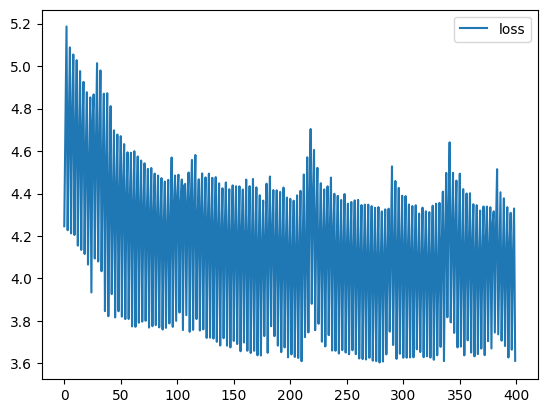

In [185]:
from IPython.display import clear_output #запустим нейронку с подобранными параметрами

epochs = 142

opt = torch.optim.Adam(model.parameters(), lr = 0.0015)
criterion = nn.L1Loss()
history = []
for epoch in range(epochs):
    for batch, target in iterate_minibatches(X_train, y_train, batch_size=880):

        batch = torch.tensor(batch, dtype=torch.float32, device=device)

        target = torch.tensor(target, dtype=torch.float32, device=device)

        predictions = model(batch).view(-1)

        loss = criterion(predictions, target)

        opt.zero_grad()
        loss.backward()
        opt.step()

        history.append(loss.item())
        if len(history) % 100 == 0:
            clear_output(wait=True)
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

In [186]:
model.eval()
y_pred = model(torch.tensor(X_test, dtype=torch.float32, device=device))
print(f"MSE: {mean_squared_error(y_test, y_pred.detach().numpy())}")
print(f"MAE: {mean_absolute_error(y_test, y_pred.detach().numpy())}")

MSE: 151.6472642824917
MAE: 4.830504706637649


Бустинг снова показал себя лучше, что достаточно часто бывает в неструктурированных данных. У нас получилось потсроить модель, предсказывающую массу со средней ошибкой в 3,8 масс Юпитера, что конечно звучит очень внушительно, но у проекта всё-таки масштаб космический, поэтому, как мне кажется, на столь небольшом датасете, это неплохой результат.

## Выводы

На этом всё, что бы я хотел рассказать про экзопланеты, надеюсь вам, как и мне, было интересно. Во время выполнения проекта я узнал очень много нового про космос, работа с данными помогла понять как планеты открываются, какие их характеристики мы можем узнать и как они связаны между собой. Наконец, у меня появилось представление о косимческих исследованиях и о исследованной части космоса. Было также интересно посмотреть на то как можно, пусть и не супер успешно, примениить машинное обучение для предсказания характеристик планет, которые не так уж и просто померить.